In [1]:
!pip install gymnax
!pip install distrax

Episode 100: Total Reward = -200.0, Steps = 200, Epsilon = 0.606
Episode 200: Total Reward = -200.0, Steps = 200, Epsilon = 0.367
Episode 300: Total Reward = -200.0, Steps = 200, Epsilon = 0.222
Episode 400: Total Reward = -200.0, Steps = 200, Epsilon = 0.135
Episode 500: Total Reward = -200.0, Steps = 200, Epsilon = 0.082
Episode 600: Total Reward = -200.0, Steps = 200, Epsilon = 0.049
Episode 700: Total Reward = -200.0, Steps = 200, Epsilon = 0.030
Episode 800: Total Reward = -200.0, Steps = 200, Epsilon = 0.018
Episode 900: Total Reward = -200.0, Steps = 200, Epsilon = 0.011
Episode 1000: Total Reward = -200.0, Steps = 200, Epsilon = 0.010
Episode 1100: Total Reward = -200.0, Steps = 200, Epsilon = 0.010
Episode 1200: Total Reward = -168.0, Steps = 168, Epsilon = 0.010
Episode 1300: Total Reward = -160.0, Steps = 160, Epsilon = 0.010
Episode 1400: Total Reward = -163.0, Steps = 163, Epsilon = 0.010
Episode 1500: Total Reward = -200.0, Steps = 200, Epsilon = 0.010
Episode 1600: Total

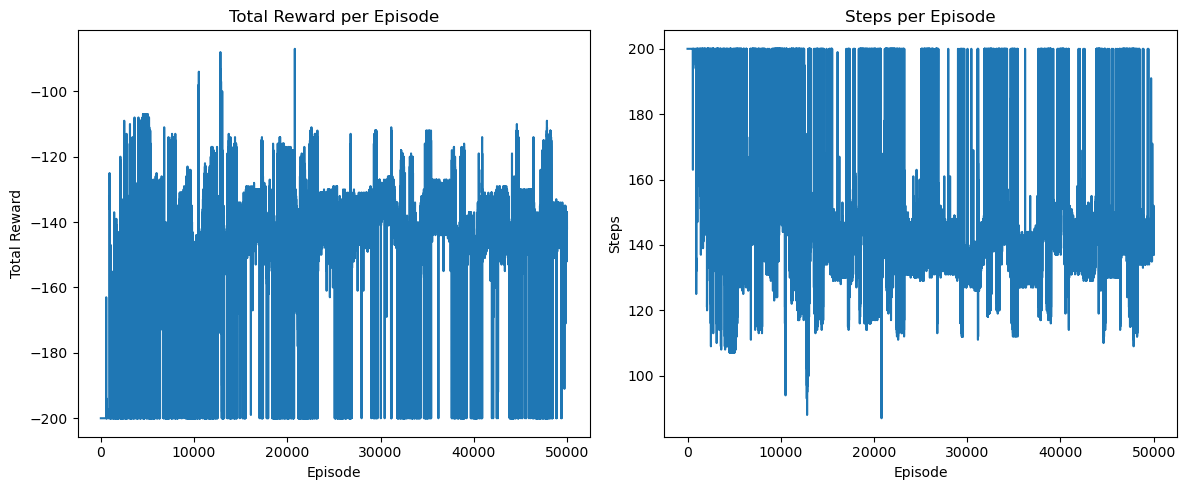

In [41]:
import numpy as np
import gymnax
import matplotlib.pyplot as plt
import jax

rng = jax.random.PRNGKey(12)

env, env_params = gymnax.make("MountainCar-v0")
rng, key_reset, key_act, key_step = jax.random.split(rng, 4)

n_position = 20  # Number of discrete positions
n_velocity = 20  # Number of discrete velocities
n_actions = env.action_space().n

def discretize_state(state, position_bins, velocity_bins):
    position, velocity = state
    position_idx = np.digitize(position, position_bins) - 1
    velocity_idx = np.digitize(velocity, velocity_bins) - 1
    return position_idx, velocity_idx

position_bins = np.linspace(env.observation_space(env_params).low[0], env.observation_space(env_params).high[0], n_position)
velocity_bins = np.linspace(env.observation_space(env_params).low[1], env.observation_space(env_params).high[1], n_velocity)

Q_table = np.zeros((n_position, n_velocity, n_actions))

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial epsilon for epsilon-greedy
epsilon_decay = 0.9995  # Decay factor for epsilon
min_epsilon = 0.01  # Minimum epsilon
episodes = 50000  # Number of training episodes

# Tracking performance
rewards_per_episode = []
steps_per_episode = []

# Q-learning algorithm
for episode in range(episodes):
    obs, state = env.reset(key_reset, env_params)
    total_reward = 0
    steps = 0
    done = False
    
    while not done:
        rng, key_reset, key_act, key_step = jax.random.split(rng, 4)
        position_idx, velocity_idx = discretize_state(obs, position_bins, velocity_bins)
        
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = np.random.choice(n_actions)  # Explore
        else:
            action = np.argmax(Q_table[position_idx, velocity_idx])  # Exploit
            
        next_obs, next_state, reward, done, _ = env.step(key_step, state, action, env_params)
        next_position_idx, next_velocity_idx = discretize_state(next_obs, position_bins, velocity_bins)
        
        # Q-learning update
        best_next_action = np.argmax(Q_table[next_position_idx, next_velocity_idx])
        td_target = reward + gamma * Q_table[next_position_idx, next_velocity_idx, best_next_action]
        td_error = td_target - Q_table[position_idx, velocity_idx, action]
        Q_table[position_idx, velocity_idx, action] += alpha * td_error
        
        state = next_state
        obs = next_obs
        total_reward += reward
        steps += 1
    
    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    
    rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Steps = {steps}, Epsilon = {epsilon:.3f}")
        
        

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(steps_per_episode)
plt.title('Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.tight_layout()
plt.show()

env.close()

In [3]:
!pip install rlinjax

ERROR: Could not find a version that satisfies the requirement rlinjax (from versions: none)
ERROR: No matching distribution found for rlinjax


{'env': <gymnax.environments.classic_control.mountain_car.MountainCar object at 0x000001F8705DFB30>, 'env_params': {'max_steps_in_episode': 200, 'min_position': -1.2, 'max_position': 0.6, 'max_speed': 0.07, 'goal_position': 0.5, 'goal_velocity': 0.0, 'force': 0.001, 'gravity': 0.0025}, 'eval_callback': <function Algorithm.create.<locals>.eval_callback at 0x000001F870E54720>, 'eval_freq': 4096, 'skip_initial_evaluation': False, 'total_timesteps': 131072, 'learning_rate': 0.0003, 'gamma': 0.99, 'max_grad_norm': inf, 'normalize_observations': False, 'target_update_freq': 1, 'polyak': 0.99, 'num_envs': 1, 'buffer_size': 131072, 'fill_buffer': 2048, 'batch_size': 256, 'eps_start': 1.0, 'eps_end': 0.05, 'exploration_fraction': 0.1, 'agent': {'hidden_layer_sizes': (64, 64), 'activation': <PjitFunction>, 'action_dim': 3, 'parent': None, 'name': None}, 'num_epochs': 1, 'ddqn': True}
Starting to train


c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 3.31488 seconds (39540.5 steps/second).


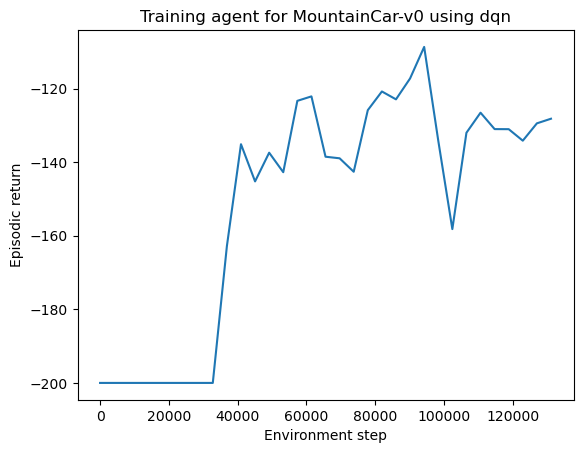

In [3]:
import time
import jax
import jax.numpy as jnp
from jax.numpy import inf
from RLinJAX import *

CONFIGS = {'total_timesteps': 100000,
           'learning_rate': 0.0003,
           'gamma': 0.9,
           'max_grad_norm': inf,
           'normalize_observations': False,
           'target_update_freq': 200,
           'polyak': 0.99,
           'num_envs': 1,
           'buffer_size': 100000,
           'fill_buffer': 1000,
           'batch_size': 100,
           "eval_freq": 5000,
           'eps_start': 1.0,
           'eps_end': 0.01,
           'exploration_fraction': 0.5, 
           'agent': {'hidden_layer_sizes': (64, 64), 'activation': jax.nn.relu, 'action_dim': 3, 'parent': None, 'name': None},
           'num_epochs': 5, 'ddqn': True}

algo_str = "dqn"
env_str = "MountainCar-v0"

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print(algo.config)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()
